In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from model import UNET
from dataloader import get_loaders_heatmaps
import FILE_PATHS
import pandas as pd
import numpy as np
from training_landmarks import(
    train, 
    plot_loss_curves
)
from utils import (
    load_checkpoint,
    save_checkpoint,
    check_accuracy,
    save_predictions_as_imgs,
    train_fn
)

In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 10
NUM_WORKERS = 4
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
PIN_MEMORY = True
LOAD_MODEL = False

filename = "../EchoNet-Dynamic/models/landmark_model.pth.tar"

In [3]:
# Transformations
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [4]:
# MODEL
model = UNET(in_channels=3, out_channels=7).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
# BATCHES
train_loader, val_loader = get_loaders_heatmaps(
    FILE_PATHS.IMAGES,
    f"{FILE_PATHS.HEATMAPS}/gaussian",
    FILE_PATHS.MASKS,
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    NUM_WORKERS,
    test_size=0.2,
    seed=42,
)

TRAIN PATHS LENGTHS: images, masks, heatmaps
25, 25, 25
VALIDATION PATHS LENGTHS: images, masks, heatmaps
7, 7, 7


In [6]:
if LOAD_MODEL:
    load_checkpoint(torch.load("landmark_model.pth.tar"), model)

landmark_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0692 | train_acc: 0.1525 | test_loss: 0.0690 | test_acc: 0.2220


 10%|█         | 1/10 [00:16<02:25, 16.19s/it]

Epoch: 2 | train_loss: 0.0686 | train_acc: 0.1407 | test_loss: 0.0690 | test_acc: 0.2204


 20%|██        | 2/10 [00:30<02:02, 15.34s/it]

Epoch: 3 | train_loss: 0.0681 | train_acc: 0.1681 | test_loss: 0.0690 | test_acc: 0.2789


 30%|███       | 3/10 [00:44<01:40, 14.36s/it]

Epoch: 4 | train_loss: 0.0677 | train_acc: 0.1921 | test_loss: 0.0690 | test_acc: 0.3155


 40%|████      | 4/10 [00:56<01:22, 13.77s/it]

Epoch: 5 | train_loss: 0.0673 | train_acc: 0.2245 | test_loss: 0.0690 | test_acc: 0.2350


 50%|█████     | 5/10 [01:09<01:05, 13.13s/it]

Epoch: 6 | train_loss: 0.0668 | train_acc: 0.2356 | test_loss: 0.0690 | test_acc: 0.1627


 60%|██████    | 6/10 [01:21<00:51, 12.76s/it]

Epoch: 7 | train_loss: 0.0664 | train_acc: 0.2524 | test_loss: 0.0690 | test_acc: 0.2407


 70%|███████   | 7/10 [01:35<00:39, 13.21s/it]

Epoch: 8 | train_loss: 0.0659 | train_acc: 0.2104 | test_loss: 0.0690 | test_acc: 0.2332


 80%|████████  | 8/10 [01:47<00:25, 12.95s/it]

Epoch: 9 | train_loss: 0.0654 | train_acc: 0.2314 | test_loss: 0.0690 | test_acc: 0.1993


 90%|█████████ | 9/10 [02:00<00:12, 12.85s/it]

Epoch: 10 | train_loss: 0.0648 | train_acc: 0.2284 | test_loss: 0.0690 | test_acc: 0.2373


100%|██████████| 10/10 [02:15<00:00, 13.53s/it]


In [8]:
# save model
checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}

save_checkpoint(checkpoint, filename)

=> Saving checkpoint


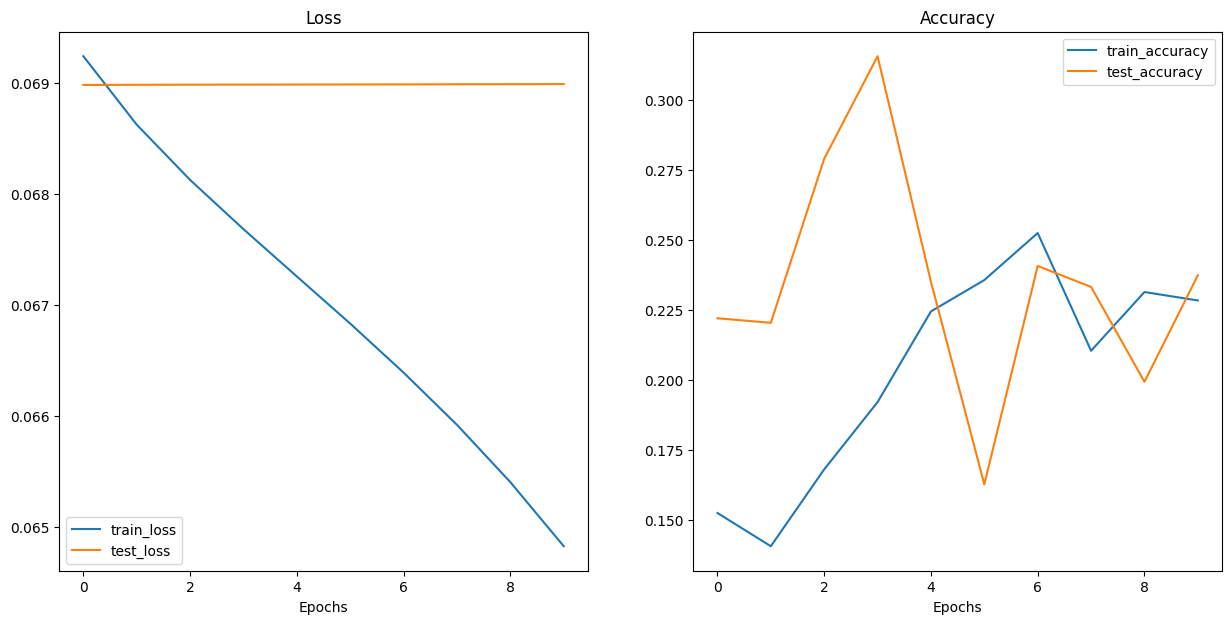

In [9]:
plot_loss_curves(landmark_results)

In [10]:
landmark_model = pd.DataFrame(landmark_results)
landmark_model.to_csv("mask_model.csv")
